In [1]:
import base64
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pprint
import json
import seaborn as sns
import re
import os

from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

def compute_polygon(polygon_type, coords):
    x12 = (coords['img1']['x'] + coords['img1']['width'] + coords['img2']['x'])/2
    x23 = (coords['img2']['x'] + coords['img2']['width'] + coords['img3']['x'])/2
    y12 = (coords['sent_msg']['y'] + coords['sent_msg']['height'] + coords['img1']['y'])/2
    y23 = (coords['img1']['y'] + coords['img1']['height'] + coords['available_msgs']['y'])/2
    match polygon_type:
        case 'sent_msg':
            return Polygon([(x23+x12/2, 0), (x12/2, 0), (x12, y12), (x23, y12)])
        case 'img1':
            return Polygon([(0, y12/2), (x12, y12), (x12, y23), (0, y23+y12/2)])
        case 'img2':
            return Polygon([(x12, y12), (x23, y12), (x23, y23), (x12, y23)])
        case 'img3':
            return Polygon([(x23, y12), (x12+x23, y12/2), (x12+x23, y23+y12/2), (x23, y23)])
        case 'available_msgs':
            return Polygon([(x12, y23), (x23, y23), (x23+x12/2, y12+y23), (x12/2, y12+y23)])


def count_gaze(gaze, polygon, participant=None):
    count = 0
    # check if there is gaze is not empty
    if not gaze:
        return 0
    for _, val in gaze.items():
        point = Point(val['x'], val['y'])
        if polygon.contains(point):
            count += 1
    return count

def merge_msgs_coords(coords):
    coords['available_msgs'] = {'height': coords['msg1']['height'], 'width': coords['msg4']['x'] + coords['msg4']['width'] - coords['msg1']['x'], 'x': coords['msg1']['x'], 'y': coords['msg1']['y']}
    return coords

pp = pprint.PrettyPrinter(indent=4)

dict_list_columns = ['objs', 'msgsOrder', 'calibrationPrecision', 'gaze', 'coordinates', 'deviceInfo']
df_name = 'final_experiment'

In [2]:
remove_negative_gaze = False
filter_blacklist = True

blacklist = ['65ec84d7abc1df34e678abe1', '600a3f4dfab4f005387beff6', '63d1412396ee4fa133b52643', # invalid data 
             '6711572aa22f0638a3f67bd6', '672cb407e8fe02325f9515e9', '677551520baf8b896f43f4a2'  # accuracy on unambiguous trials <= 0.5
             ]
df = pd.read_csv(f'data/raw_data/{df_name}.csv')

# the csvs had a double column, fixed for final_experiment.csv
# df = df.drop('type', axis=1)

if filter_blacklist:
    df = df[~df['workerid'].isin(blacklist)]

# reindex the df
df.reset_index(drop=True, inplace=True)

def parse(data):
    while data[0] != '{':
        data = data[1:]
    while data[-1] != '}':
        data = data[:-1]
    data = data.replace('\\', '')
    data = re.sub(
        r'(?<=strategy":")(.*)(?="\})',
        lambda m: m.group(0).replace('"', '\\"'),
        data,
        count=1)
    json_data = {}
    try:
        json_data = json.loads(data)
    except:
        pp.pprint(data[-200:])
    return json_data

df = pd.concat([df, pd.json_normalize(df.apply(lambda x: parse(x['answer']), axis=1, ), max_level=0)], axis=1)

if remove_negative_gaze:
    df.gaze = df.gaze.apply(lambda x: {key:val for key, val in json.loads(base64.b64decode(x)).items() if int(key) > 0 and val['x'] is not None})
else:
    df.gaze = df.gaze.apply(lambda x: {key:val for key, val in json.loads(base64.b64decode(x)).items() if val['x'] is not None})
df.sort_values(by=['workerid', 'userTrialId'], inplace=True)
df.reset_index(drop=True, inplace=True)
df['deviceInfo'] = df['deviceInfo'].ffill()
df['calibrationPrecision'] = df['calibrationPrecision'].ffill()

In [3]:
len(df.workerid.unique())

102

### Convert Gaze to Fixation detection format
#### After consideration, fixation detection does not seem like a good choice for our data

In [8]:
# # ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
# for participant in df['workerid'].unique():
#     participant_df = df[df['workerid'] == participant]
#     participant_df.reset_index(drop=True, inplace=True)
#     x = participant_df['gaze'].apply(lambda gaze: [gaze[key]['x'] for key in gaze.keys()])
#     y = participant_df['gaze'].apply(lambda gaze: [gaze[key]['y'] for key in gaze.keys()])
#     time = participant_df['gaze'].apply(lambda gaze: [int(key) for key in gaze.keys()])
#     # shift all values to remove negative values
#     time = time.apply(lambda x: [i - min(x) for i in x])
#     prep_df = pd.DataFrame({'trial': participant_df['userTrialId'],'x': x, 'y': y, 'time': time})
#     prep_df = prep_df.explode(['x','y','time'])
#     prep_df.sort_values(by=['trial', 'time'], inplace=True)
#     prep_df.to_csv(f'data/participants_raw_gaze/{participant}.csv', index=False)

# import subprocess
# subprocess.call("/usr/bin/Rscript --vanilla ~/uds/thesis/Thesis-Project/analysis/fixations.r", shell=True)

# for participant in df['workerid'].unique():
#     participant_fixations = pd.read_csv(f'data/participants_fixations/{participant}.csv')

#     fixations = participant_fixations.groupby('trial').apply(lambda x: x.to_dict(orient='records')).to_dict()
#     print(fixations)
#     df.loc[df['workerid'] == participant, 'fixations'] = df[df['workerid'] == participant]['userTrialId'].apply(lambda x: fixations[x] if x in fixations else [])
    

## Gen Features

In [4]:
df['answerAccuracy'] = df.groupby('workerid')['correct'].transform('mean')
df['answerAccuracySimple'] = df[df['type'].isin(['simple','strategy_simple'])].groupby('workerid')['correct'].transform('mean')
df['answerAccuracyComplex'] = df[df['type'].isin(['complex', 'strategy_complex'])].groupby('workerid')['correct'].transform('mean')
df['answerAccuracyUnambiguous'] = df[df['type'] == 'unambiguous'].groupby('workerid')['correct'].transform('mean')
df['resolution'] = df.deviceInfo.apply(lambda x: [int(size) for size in x['screen'].split('x')])
df['coordinates'] = df.apply(lambda x: merge_msgs_coords(x['coordinates']), axis=1)
df['timeOnSentMsg'] = df.apply(lambda x: count_gaze(x['gaze'], compute_polygon('sent_msg', x['coordinates']), x['workerid']), axis=1) 
df['timeOnSentMsgSimple'] = df[df['type'].isin(['simple','strategy_simple'])].apply(lambda x: x['timeOnSentMsg'], axis=1)
df['timeOnSentMsgComplex'] = df[df['type'].isin(['complex', 'strategy_complex'])].apply(lambda x: x['timeOnSentMsg'], axis=1)
df['timeOnSentMsgUnambiguous'] = df[df['type'] == 'unambiguous'].apply(lambda x: x['timeOnSentMsg'], axis=1)
df['timeOnAvailableMsgs'] = df.apply(lambda x: count_gaze(x['gaze'], compute_polygon('available_msgs', x['coordinates'])), axis=1)
df['timeOnAvailableMsgsSimple'] = df[df['type'].isin(['simple','strategy_simple'])].apply(lambda x: x['timeOnAvailableMsgs'], axis=1)
df['timeOnAvailableMsgsComplex'] = df[df['type'].isin(['complex', 'strategy_complex'])].apply(lambda x: x['timeOnAvailableMsgs'], axis=1)
df['timeOnAvailableMsgsUnambiguous'] = df[df['type'] == 'unambiguous'].apply(lambda x: x['timeOnAvailableMsgs'], axis=1)
df['timeOnImg1'] = df.apply(lambda x: count_gaze(x['gaze'], compute_polygon('img1', x['coordinates'])), axis=1)
df['timeOnImg2'] = df.apply(lambda x: count_gaze(x['gaze'], compute_polygon('img2', x['coordinates'])), axis=1)
df['timeOnImg3'] = df.apply(lambda x: count_gaze(x['gaze'], compute_polygon('img3', x['coordinates'])), axis=1)
df['timeOnTrgt'] = df.apply(lambda x: x[('timeOnImg' + str(1 + x['trgtPos']))], axis=1)
df['timeOnTrgtSimple'] = df[df['type'].isin(['simple','strategy_simple'])].apply(lambda x: x[('timeOnImg' + str(1 + x['trgtPos']))], axis=1)
df['timeOnTrgtComplex'] = df[df['type'].isin(['complex', 'strategy_complex'])].apply(lambda x: x[('timeOnImg' + str(1 + x['trgtPos']))], axis=1)
df['timeOnTrgtUnambiguous'] = df[df['type'] == 'unambiguous'].apply(lambda x: x[('timeOnImg' + str(1 + x['trgtPos']))], axis=1)
df['timeOnDist'] = df.apply(lambda x: x[('timeOnImg' + str(1 + x['distPos']))], axis=1)
df['timeOnDistSimple'] = df[df['type'].isin(['simple','strategy_simple'])].apply(lambda x: x[('timeOnImg' + str(1 + x['distPos']))], axis=1)
df['timeOnDistComplex'] = df[df['type'].isin(['complex', 'strategy_complex'])].apply(lambda x: x[('timeOnImg' + str(1 + x['distPos']))], axis=1)
df['timeOnDistUnambiguous'] = df[df['type'] == 'unambiguous'].apply(lambda x: x[('timeOnImg' + str(1 + x['distPos']))], axis=1)
df['timeOnComp'] = df.apply(lambda x: x[('timeOnImg' + str(1 + x['compPos']))], axis=1)
df['timeOnCompSimple'] = df[df['type'].isin(['simple','strategy_simple'])].apply(lambda x: x[('timeOnImg' + str(1 + x['compPos']))], axis=1)
df['timeOnCompComplex'] = df[df['type'].isin(['complex', 'strategy_complex'])].apply(lambda x: x[('timeOnImg' + str(1 + x['compPos']))], axis=1)
df['timeOnCompUnambiguous'] = df[df['type'] == 'unambiguous'].apply(lambda x: x[('timeOnImg' + str(1 + x['compPos']))], axis=1)
df['timeOnAOI'] = df.apply(lambda x: sum(x[['timeOnSentMsg', 'timeOnAvailableMsgs', 'timeOnImg1', 'timeOnImg2', 'timeOnImg3']]), axis=1)
df['timeOnTrial'] = df.apply(lambda x: len(x['gaze']), axis=1)
df['timeOnNonAOI'] = df.apply(lambda x: x['timeOnTrial'] - x['timeOnAOI'], axis=1)
df['timeOnNonAOISimple'] = df.apply(lambda x: x['timeOnTrial'] - sum(x[['timeOnSentMsgSimple', 'timeOnAvailableMsgsSimple', 'timeOnTrgtSimple', 'timeOnCompSimple', 'timeOnDistSimple']]), axis=1)
df['timeOnNonAOIComplex'] = df.apply(lambda x: x['timeOnTrial'] - sum(x[['timeOnSentMsgComplex', 'timeOnAvailableMsgsComplex', 'timeOnTrgtComplex', 'timeOnCompComplex', 'timeOnDistComplex']]), axis=1)
df['timeOnNonAOIUnambiguous'] = df.apply(lambda x: x['timeOnTrial'] - sum(x[['timeOnSentMsgUnambiguous', 'timeOnAvailableMsgsUnambiguous', 'timeOnTrgtUnambiguous', 'timeOnCompUnambiguous', 'timeOnDistUnambiguous']]), axis=1)
df['propTimeOnNonAOI'] = df['timeOnNonAOI'] / df['timeOnTrial']
df['propTimeOnNonAOISimple'] = df['timeOnNonAOISimple'] / df['timeOnTrial']
df['propTimeOnNonAOIComplex'] = df['timeOnNonAOIComplex'] / df['timeOnTrial']
df['propTimeOnNonAOIUnambiguous'] = df['timeOnNonAOIUnambiguous'] / df['timeOnTrial']
df['propTimeOnSentMsg'] = df['timeOnSentMsg'] / df['timeOnTrial']
df['propTimeOnSentMsgSimple'] = df['timeOnSentMsgSimple'] / df['timeOnTrial']
df['propTimeOnSentMsgComplex'] = df['timeOnSentMsgComplex'] / df['timeOnTrial']
df['propTimeOnSentMsgUnambiguous'] = df['timeOnSentMsgUnambiguous'] / df['timeOnTrial']
df['propTimeOnAvailableMsgs'] = df['timeOnAvailableMsgs'] / df['timeOnTrial']
df['propTimeOnAvailableMsgsSimple'] = df['timeOnAvailableMsgsSimple'] / df['timeOnTrial']
df['propTimeOnAvailableMsgsComplex'] = df['timeOnAvailableMsgsComplex'] / df['timeOnTrial']
df['propTimeOnAvailableMsgsUnambiguous'] = df['timeOnAvailableMsgsUnambiguous'] / df['timeOnTrial']
df['propTimeOnTrgt'] = df['timeOnTrgt'] / df['timeOnTrial']
df['propTimeOnTrgtSimple'] = df['timeOnTrgtSimple'] / df['timeOnTrial']
df['propTimeOnTrgtComplex'] = df['timeOnTrgtComplex'] / df['timeOnTrial']
df['propTimeOnTrgtUnambiguous'] = df['timeOnTrgtUnambiguous'] / df['timeOnTrial']
df['propTimeOnDist'] = df['timeOnDist'] / df['timeOnTrial']
df['propTimeOnDistSimple'] = df['timeOnDistSimple'] / df['timeOnTrial']
df['propTimeOnDistComplex'] = df['timeOnDistComplex'] / df['timeOnTrial']
df['propTimeOnDistUnambiguous'] = df['timeOnDistUnambiguous'] / df['timeOnTrial']
df['propTimeOnComp'] = df['timeOnComp'] / df['timeOnTrial']
df['propTimeOnCompSimple'] = df['timeOnCompSimple'] / df['timeOnTrial']
df['propTimeOnCompComplex'] = df['timeOnCompComplex'] / df['timeOnTrial']
df['propTimeOnCompUnambiguous'] = df['timeOnCompUnambiguous'] / df['timeOnTrial']

msg_type = {'ci': 'shape',
            'sq': 'shape',
            'tr': 'shape',
            'bl': 'color',
            're': 'color',
            'gr': 'color'}
df['msgType'] = df['sent_msg'].map(msg_type)

df['condition'] = df['type'].map({'simple': 'simple', 'complex': 'complex', 'strategy_simple': 'simple', 'strategy_complex': 'complex', 'unambiguous': 'unambiguous'})

df['meanAnswerTime'] = df.groupby('workerid')['answerTime'].transform('mean')
df['meanAnswerTimeSimple'] = df[df['condition'] == 'simple'].groupby('workerid')['answerTime'].transform('mean')
df['meanAnswerTimeComplex'] = df[df['condition'] == 'complex'].groupby('workerid')['answerTime'].transform('mean')
df['meanAnswerTimeUnambiguous'] = df[df['condition'] == 'unambiguous'].groupby('workerid')['answerTime'].transform('mean')

dict_list_columns = ['objs', 'msgsOrder', 'calibrationPrecision', 'gaze', 'coordinates', 'deviceInfo']

for dict_column in dict_list_columns:
    df[dict_column] = df[dict_column].apply(lambda x: json.dumps(x))

df.to_csv(f'data/preprocessed_data/{df_name}.csv', index=False)

## Explode Gaze and Create CSV per Fixation

In [12]:
filter_correct = True
df = pd.read_csv(f'data/preprocessed_data/{df_name}.csv')    
for column in dict_list_columns:
    try:
        df[column] = df[column].apply(lambda x: json.loads(x))
    except:
        print(column)
gaze_df = df[['workerid', 'userTrialId', 'correct', 'answerTime', 'gaze', 'trgtPos', 'distPos', 'compPos', 'coordinates', 'condition', 'msgType']]
if filter_correct:
    gaze_df = gaze_df[gaze_df['correct'] == 1]
def detect_aoi(point, coords):
    for aoi in ['sent_msg', 'img1', 'img2', 'img3', 'available_msgs']:
        polygon = compute_polygon(aoi, coords)
        if polygon.contains(point):
            return aoi
    return 'non_aoi'

def explode_gaze(row):
    x = []
    y = []
    time = []
    aois = []
    subject = row['workerid']
    trial = row['userTrialId']
    condition = row['condition']
    msg_type = row['msgType']
    trgt_pos = row['trgtPos']
    if not filter_correct:
        correct = row['correct']
    for key, val in row['gaze'].items():
        x.append(val['x'])
        y.append(val['y'])
        time.append(int(key))
        point = Point(val['x'], val['y'])
        img_to_obj = {row['trgtPos'] : 'trgt', row['distPos'] : 'dist', row['compPos'] : 'comp'}
        aoi = detect_aoi(point, row['coordinates'])
        if aoi in ['img1', 'img2', 'img3']:
            aoi = img_to_obj[int(aoi[-1])-1]
        aois.append(aoi)
    if filter_correct:
        return pd.DataFrame({'Subject': subject, 'Trial': trial, 'Condition': condition, 'MsgType': msg_type, 'TrgtPos': trgt_pos, 'Time': time, 'AOI': aois})
    else:
        return pd.DataFrame({'Subject': subject, 'Trial': trial, 'Condition': condition, 'MsgType': msg_type, 'TrgtPos': trgt_pos, 'Time': time, 'Correct': correct, 'AOI': aois})
pd.concat(np.array(gaze_df.apply(lambda x: explode_gaze(x), axis=1)).flatten(), axis=0).to_csv(f'data/final_datasets/{df_name}_{'correct_' if filter_correct else ''}fixations.csv', index=False)

# Final Feature CSV per Trial

In [13]:
df = pd.read_csv(f'data/preprocessed_data/{df_name}.csv')
final_df_features = ['workerid',
                     'userTrialId',
                     'condition',
                     'correct',
                     'answerTime',
                     'propTimeOnSentMsg',
                     'propTimeOnTrgt',
                     'propTimeOnDist',
                     'propTimeOnComp',
                     'propTimeOnAvailableMsgs',
                     'propTimeOnNonAOI',
                     'trgtPos',
                     'msgType'
                    ]
final_df = df[final_df_features]
final_df = final_df.rename(columns={'workerid': 'Subject',
                                    'userTrialId': 'Trial',
                                    'condition': 'Condition',
                                    'correct': 'Correct',
                                    'answerTime': 'AnswerTime',
                                    'propTimeOnSentMsg': 'PropTimeOnSentMsg',
                                    'propTimeOnTrgt': 'PropTimeOnTrgt',
                                    'propTimeOnDist': 'PropTimeOnDist',
                                    'propTimeOnComp': 'PropTimeOnComp',
                                    'propTimeOnAvailableMsgs': 'PropTimeOnAvailableMsgs',
                                    'propTimeOnNonAOI': 'PropTimeOnNonAOI',
                                    'trgtPos': 'TrgtPos',
                                    'msgType': 'MsgType'})
final_df.to_csv(f'data/final_datasets/{df_name}_trials.csv', index=False)
final_df.head()

,Subject,Trial,Condition,Correct,AnswerTime,PropTimeOnSentMsg,PropTimeOnTrgt,PropTimeOnDist,PropTimeOnComp,PropTimeOnAvailableMsgs,PropTimeOnNonAOI,TrgtPos,MsgType
0,5723714684458100120292f6,0,complex,1,5528,0.000000,0.277193,0.185965,0.473684,0.056140,0.007018,2,color
1,5723714684458100120292f6,1,unambiguous,1,2711,0.300000,0.450000,0.166667,0.050000,0.000000,0.033333,1,shape
2,5723714684458100120292f6,2,unambiguous,1,1938,0.418605,0.232558,0.255814,0.093023,0.000000,0.000000,0,color
3,5723714684458100120292f6,3,simple,1,6226,0.262774,0.350365,0.007299,0.072993,0.299270,0.007299,1,shape
4,5723714684458100120292f6,4,simple,1,3067,0.264706,0.205882,0.000000,0.132353,0.397059,0.000000,2,color


## Final Feature CSV per Participant

In [6]:
df = pd.read_csv(f'data/preprocessed_data/{df_name}.csv')
final_df_features = ['propTimeOnSentMsg',
                        'propTimeOnSentMsgSimple',
                        'propTimeOnSentMsgComplex',
                        'propTimeOnSentMsgUnambiguous',
                        'propTimeOnAvailableMsgs',
                        'propTimeOnAvailableMsgsSimple',
                        'propTimeOnAvailableMsgsComplex',
                        'propTimeOnAvailableMsgsUnambiguous',
                        'propTimeOnTrgt',
                        'propTimeOnTrgtSimple',
                        'propTimeOnTrgtComplex',
                        'propTimeOnTrgtUnambiguous',
                        'propTimeOnDist',
                        'propTimeOnDistSimple',
                        'propTimeOnDistComplex',
                        'propTimeOnDistUnambiguous',
                        'propTimeOnComp',
                        'propTimeOnCompSimple',
                        'propTimeOnCompComplex',
                        'propTimeOnCompUnambiguous',
                        'propTimeOnNonAOI',
                        'propTimeOnNonAOISimple',
                        'propTimeOnNonAOIComplex',
                        'propTimeOnNonAOIUnambiguous',
                        'meanAnswerTime',
                        'meanAnswerTimeSimple',
                        'meanAnswerTimeComplex',
                        'meanAnswerTimeUnambiguous',
                        'answerAccuracy',
                        'answerAccuracySimple',
                        'answerAccuracyComplex',
                        'answerAccuracyUnambiguous',
                     ]
final_df = df.groupby('workerid', sort=False, as_index=False)[final_df_features].mean()
# Save the final df
unambiguous_performance = final_df.workerid[final_df[['workerid', 'answerAccuracyUnambiguous']].apply(lambda x: x['answerAccuracyUnambiguous'] <= 0.5, axis=1)].reset_index(drop=True)
if not unambiguous_performance.empty:
    print("!!!Warning!!!")
    print("The following participants have accuracy less or equal than 0.5")
    print("Consider removing them from the analysis:")
    print(unambiguous_performance)

final_df.to_csv(f'data/final_datasets/{df_name}_participants_extended.csv', index=False)

conditional_dfs = []
conditions = ['simple', 'complex', 'unambiguous']

final_conditions = ['all'] + conditions

def explode_by_condition(row):
    for condition in final_conditions:
        condition_str = '' if condition == 'all' else condition[0].upper() + condition[1:]
        yield pd.DataFrame({'Subject': row['workerid'], 
                             'Condition': condition,
                             'PropTimeOnSentMsg': row['propTimeOnSentMsg' + condition_str],
                             'PropTimeOnAvailableMsgs': row['propTimeOnAvailableMsgs' + condition_str],
                             'PropTimeOnTrgt': row['propTimeOnTrgt' + condition_str],
                             'PropTimeOnDist': row['propTimeOnDist' + condition_str],
                             'PropTimeOnComp': row['propTimeOnComp' + condition_str],
                             'PropTimeOnNonAOI': row['propTimeOnNonAOI' + condition_str],
                             'MeanAnswerTime': row['meanAnswerTime' + condition_str],
                             'AnswerAccuracy': row['answerAccuracy' + condition_str]},
                             index=[0])
            
df_array = np.array(final_df.apply(lambda x: pd.concat(list(explode_by_condition(x)), axis=0), axis=1))
final_df_condition = pd.concat(df_array, axis=0)
final_df_condition.to_csv(f'data/final_datasets/{df_name}_participants.csv', index=False)

### Fitting Some Regressions

[0.73932876 0.09287049 0.06902342 0.04614951 0.03279965 0.01982818]


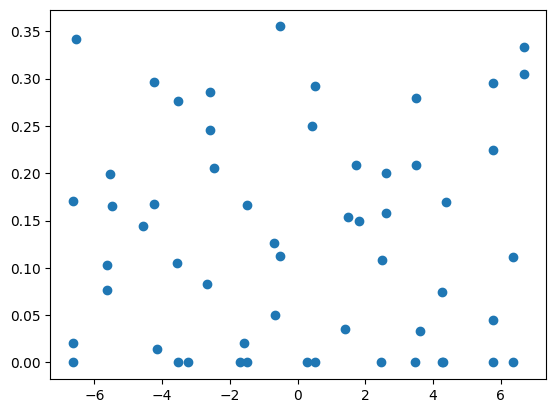

In [ ]:
import math

def logit(x):
    odds = x/(1-x)
    if (x/1-x) >= 1:
        odds -= 1e-10
    elif (x/1-x) <= 0:
        odds += 1e-9
    return math.log(odds)

fit_df = pd.read_csv('data/final_datasets/.csv')


features = ['TrgtPosLeftRight', 'TrgtPosMiddle', 'Trial', 'MsgColorShape', 'SimpleComplex', 'Unambiguous']
# code 3 conditions into 2 columns of binary values

code = [[ 1, -1],
        [-1, -1],
        [ 0,  2]]

simple_vs_complex = {'simple': 1, 'complex': -1, 'unambiguous': 0, 'strategy_simple': 1, 'strategy_complex': -1}
left_vs_right = [1, 0, -1]
color_vs_shape = {'color': 1, 'shape': -1}
fit_df['TrgtPosLeftRight'] = fit_df['TargetPosition'].apply(lambda x: left_vs_right[x])
fit_df['TrgtPosMiddle'] = fit_df['TargetPosition'].apply(lambda x: 2 if x == 1 else -1)
fit_df['MsgColorShape'] = fit_df['MsgType'].map(color_vs_shape)
fit_df['SimpleComplex'] = fit_df['Condition'].map(simple_vs_complex)
fit_df['Unambiguous'] = fit_df['Condition'].apply(lambda x: 2 if x == 'unambiguous' else -1)
fit_df['PropTimeOnAvailableMsgsLog'] = fit_df['PropTimeOnAvailableMsgs'].apply(lambda x: logit(x))
fit_df['Trial'] = fit_df['Trial']-fit_df['Trial'].median()

x = fit_df[features]
y = fit_df['PropTimeOnAvailableMsgs']

fit_df[['PropTimeOnAvailableMsgsLog', 'PropTimeOnAvailableMsgs']].head()

# apply pca and report the explained variance
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(x)
explained_variance = pca.explained_variance_ratio_
print(explained_variance)

# plot first principal component against target variable
pca = PCA(n_components=1)
pca.fit(x)
x_pca = pca.transform(x)
plt.scatter(x_pca, y)



In [ ]:

# fit linear regression and report correlation of features to target
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(x, y)
y_pred = reg.predict(x)

coefs = np.array([features, reg.coef_]).T
print(reg.score(x, y))
print(coefs)

# # plot feature and mmodel predictions for each feature
# for feature in features:
#     plt.figure()
#     sns.scatterplot(x=fit_df[feature], y=fit_df['PropTimeOnAvailableMsgs'])
#     sns.lineplot(x=fit_df[feature], y=y_pred)


0.09889705347121003
[['TrgtPosLeftRight' '0.195964094506491']
 ['TrgtPosMiddle' '0.26409713334823387']
 ['Trial' '-0.07364645705117706']
 ['MsgColorShape' '0.09706406755204097']
 ['SimpleComplex' '-0.3035098453421854']
 ['Unambiguous' '-0.3594961067937925']]


                Subject  Trial    Condition  Correct  AnswerTime  \
0  iza_test3_11february   -6.5  unambiguous        1        9108   
1  iza_test3_11february   -5.5  unambiguous        1        2977   
2  iza_test3_11february   -4.5      complex        1       10220   
3  iza_test3_11february   -3.5      complex        1        5943   
4  iza_test3_11february   -2.5      complex        1       13538   

   PropTimeOnSentMsg  PropTimeOnTrgt  PropTimeOnDist  PropTimeOnComp  \
0           0.059259        0.133333        0.251852        0.251852   
1           0.461538        0.000000        0.230769        0.076923   
2           0.026316        0.157895        0.184211        0.184211   
3           0.170213        0.085106        0.382979        0.276596   
4           0.077922        0.000000        0.000000        0.636364   

   PropTimeOnAvailableMsgs  PropTimeOnNonAOI  TargetPosition MsgType  \
0                 0.170370          0.133333               0   shape   
1             

/home/gatemrou/venvs/ml2024/lib/python3.12/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/home/gatemrou/venvs/ml2024/lib/python3.12/site-packages/pymer4/models/Lmer.py:744: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_corrs = ran_corrs.applymap(


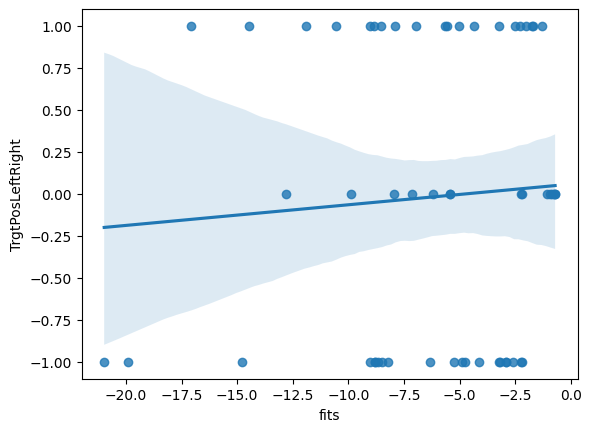

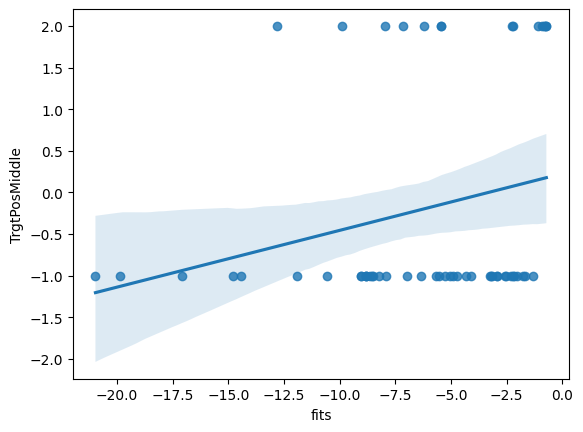

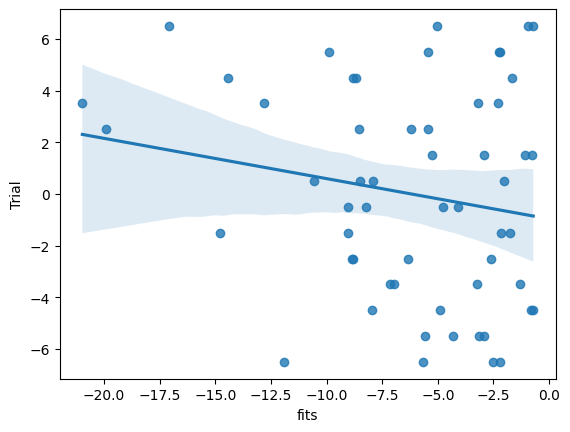

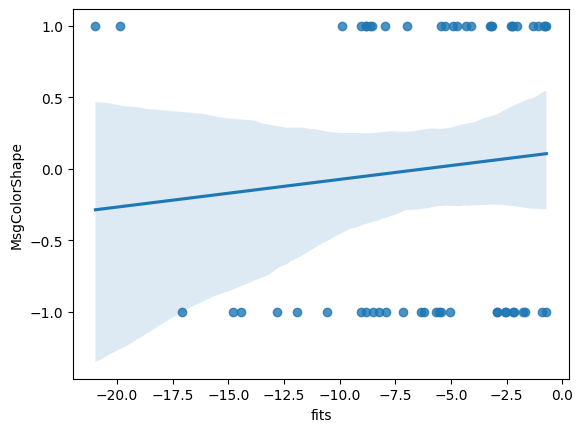

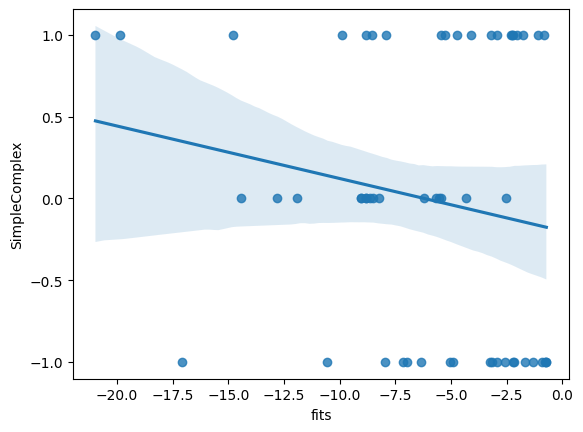

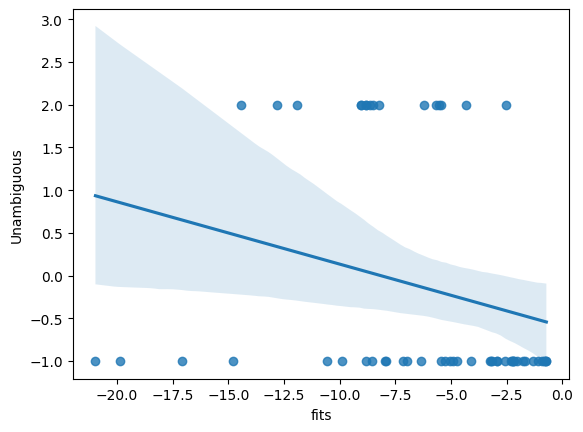

In [ ]:

from pymer4.models import Lmer

print(fit_df.head())
reg = Lmer('PropTimeOnAvailableMsgsLog ~ TrgtPosLeftRight + TrgtPosMiddle + MsgColorShape + SimpleComplex + Unambiguous + Trial + (1 + TrgtPosLeftRight + TrgtPosMiddle + SimpleComplex + Unambiguous + Trial|Subject)', data=fit_df)
print(reg.fit())

# plot feature and model predictions for each feature
for feature in features:
    plt.figure()
    sns.regplot(x='fits', y=feature, data=reg.data, fit_reg=True)



In [ ]:
# print(sum([df['propTimeOnNonAOIUnambiguous'].mean(), df['propTimeOnSentMsgUnambiguous'].mean(), df['propTimeOnTrgtUnambiguous'].mean(), df['propTimeOnDistUnambiguous'].mean(), df['propTimeOnCompUnambiguous'].mean()], df['propTimeOnAvailableMsgsUnambiguous'].mean()))
print(df['propTimeOnTrgtComplex'].mean(), df['propTimeOnTrgtSimple'].mean(), df['propTimeOnTrgtUnambiguous'].mean(), df['propTimeOnTrgt'].mean())
# df[['propTimeOnTrgtComplex', 'propTimeOnTrgtSimple', 'propTimeOnTrgtUnambiguous', 'propTimeOnTrgt']]

0.3276323273751244 0.15332341063343208 0.14917432029904992 0.2116451694131535


In [ ]:
df = pd.read_csv(f'data/preprocessed_data/{df_name}.csv')
df['coordinates'] = df['coordinates'].apply(lambda x: json.loads(x))
df['gaze'] = df['gaze'].apply(lambda x: json.loads(x))

def gen_plot(workerid, trial_id, gaze, coords, trgt_pos, comp_pos, condition, correct):
    try:
        window_resolution = [coords['img1']['x'] + coords['img3']['x'] + coords['img3']['width'], 
                            2*coords['img1']['y'] + coords['img1']['height']]
    except:
        print(coords)
    imgs = ['img1', 'img2', 'img3', 'sent_msg', 'available_msgs']
    x, y = [], []
    x = np.array([val['x'] for val in gaze.values()])
    y = np.array([val['y'] for val in gaze.values()])
    plt.figure(figsize=(window_resolution[0]*6/window_resolution[1], 6))
    for i in range(len(x)):
        plt.plot(x[i], y[i], color=(0, 0, i/len(x)), marker='o')
    plt.xlim(0, window_resolution[0])
    plt.ylim(0, window_resolution[1])
    for i, area in enumerate(imgs):
        cur_coords = coords[area]
        x_min = max(0, cur_coords['x'])
        x_max = cur_coords['x'] + cur_coords['width']
        y_min = max(0, cur_coords['y'])
        y_max = cur_coords['y'] + cur_coords['height']
        # plot boxes that mark images
        color = (1, 0, 0)
        if trgt_pos == i:
            color = (0, 1, 0)
        elif comp_pos == i:
            color = (1, 1, 0)
        elif area == 'sent_msg':
            color = (0, 1, 1)
        elif area == 'available_msgs':
            color = (1, 0, 1)
        plt.plot([x_min, x_max, x_max, x_min, x_min], [y_min, y_min, y_max, y_max, y_min], linewidth=3, color=color)
    plt.gca().invert_yaxis()
    plt.axis('off')
    plt.tight_layout()
    os.makedirs(f'data/gaze_plots/pilot/{condition}/{correct}/{workerid}/', exist_ok=True)
    # resize output image to 400x400 before saving
    plt.savefig(f'data/gaze_plots/pilot/{condition}/{correct}/{workerid}/{workerid}_{condition}_{trial_id}_{correct}.png', bbox_inches="tight", transparent=True, pad_inches=0)
    plt.close()

df.apply(lambda x: gen_plot(x['workerid'], x['userTrialId'], x['gaze'], x['coordinates'], x['trgtPos'], x['compPos'], x['condition'], x['correct']), axis=1)


0      None
1      None
2      None
3      None
4      None
       ... 
375    None
376    None
377    None
378    None
379    None
Length: 380, dtype: object

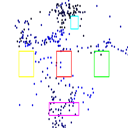

In [ ]:
from PIL import Image

img = Image.open('/home/gatemrou/uds/thesis/Thesis-Project/analysis/data/gaze_plots/tests/complex/0/j/j_complex_1_0.png', 'r')
img.resize((128, 128))

##  Leaderboard

In [16]:
df = pd.read_csv('data/preprocessed_data/final_experiment.csv')
leaderboard_df = df.sort_values(by='meanAnswerTime').sort_values(by='answerAccuracy', ascending=False, kind='stable')[['workerid', 'answerAccuracy', 'meanAnswerTime']].drop_duplicates().reset_index(drop=True)
leaderboard_df.index += 1
pp.pprint(leaderboard_df)

                     workerid  answerAccuracy  meanAnswerTime
1    5cb3cdc781f3750001043bf2        1.000000     3015.131579
2    6777b7ce13d1029c83d8d861        1.000000     3991.000000
3    63cfee97e59ec37f870b287f        1.000000     4877.078947
4    58d62c1733fef30001189b75        1.000000     6309.552632
5    665336b8da7328bc1558c1f6        1.000000     6331.078947
..                        ...             ...             ...
98   651282bee74e48b581f77d04        0.526316     7311.684211
99   5f262b3018c68e27aebdd170        0.500000     1693.026316
100  612adba08b8235b31539c704        0.500000     2975.131579
101  66d4407f31981698998d25d8        0.500000     9279.578947
102  6658c4239af9537eefdfbcc9        0.447368     2801.263158

[102 rows x 3 columns]


5797564b70c76a0001245734
{   'browser': 'Chrome',
    'browserMajorVersion': 134,
    'browserVersion': '134.0.0.0',
    'mobile': False,
    'os': 'Windows',
    'osVersion': '10',
    'screen': '1536 x 864'}
[94, 95, 76]
0 complex


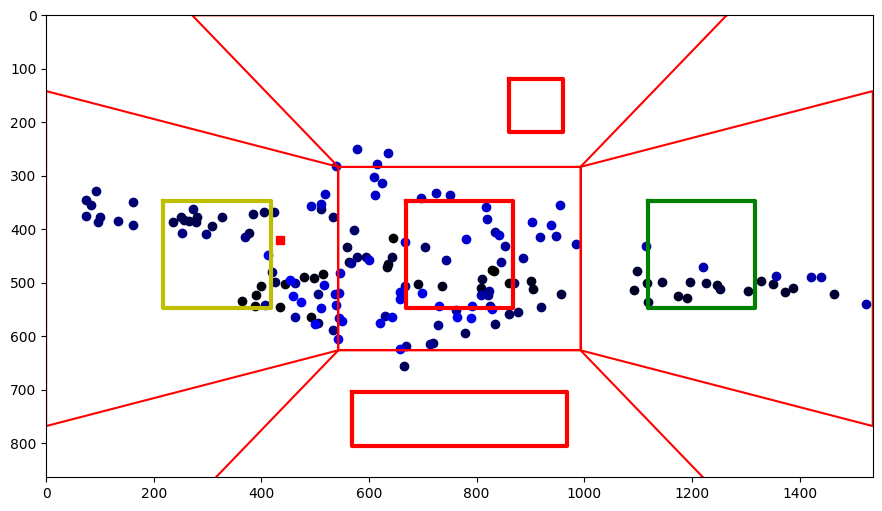

1 complex


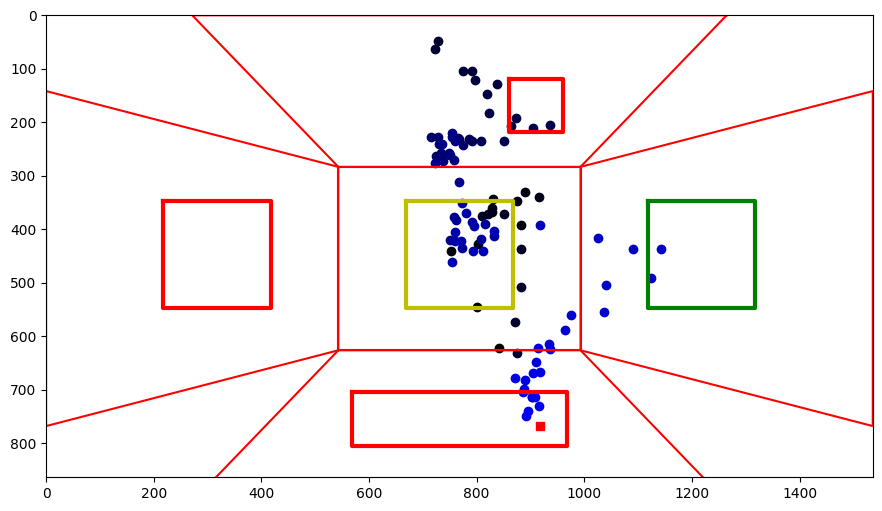

2 unambiguous


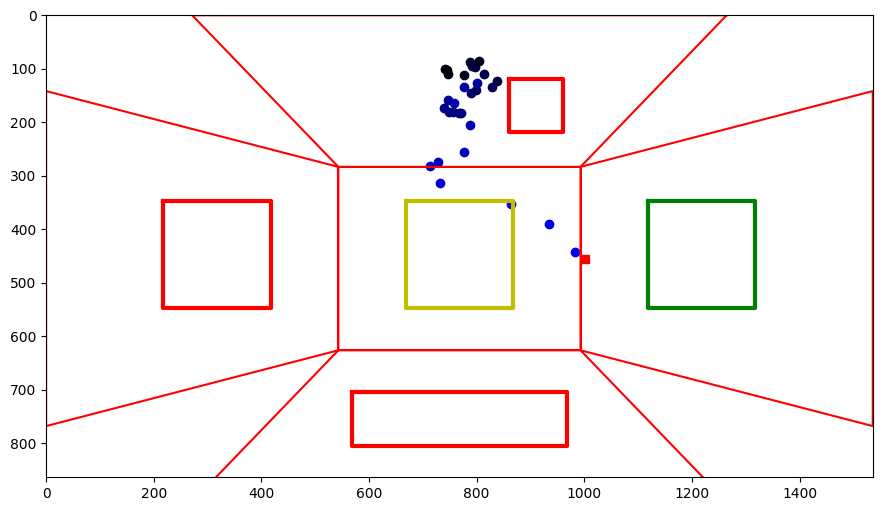

3 simple


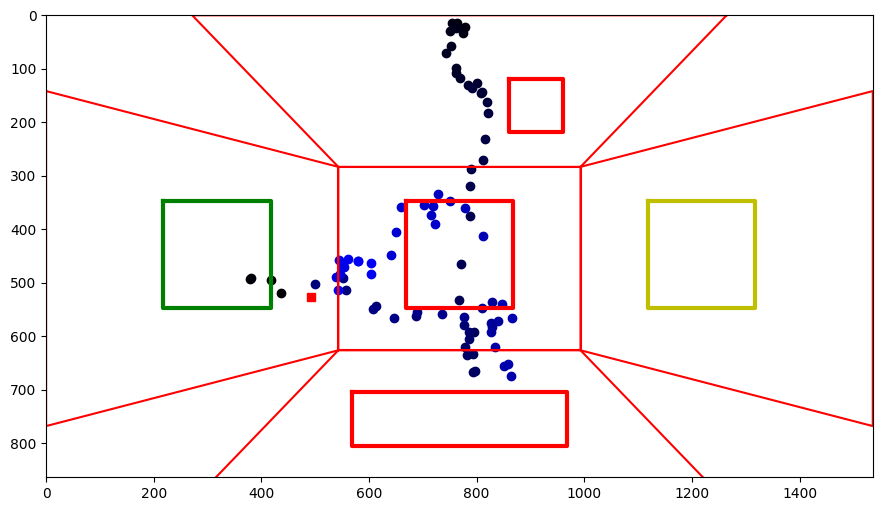

4 simple


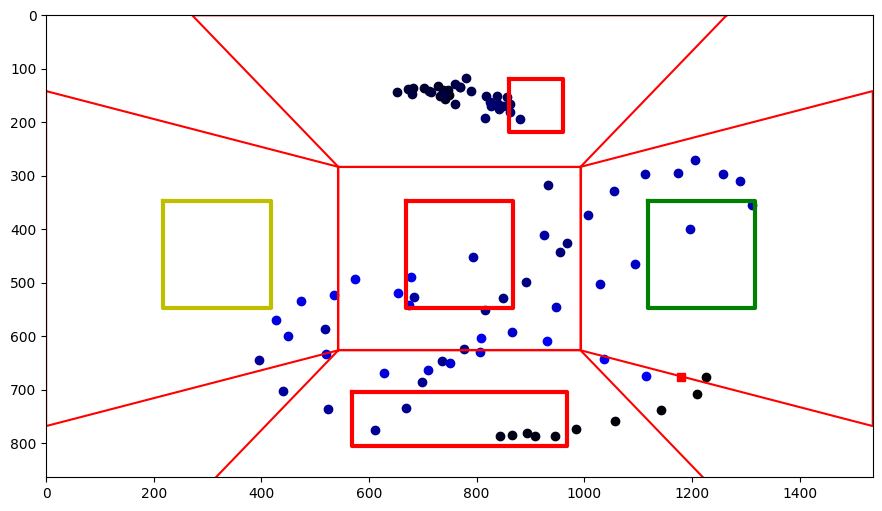

5 unambiguous


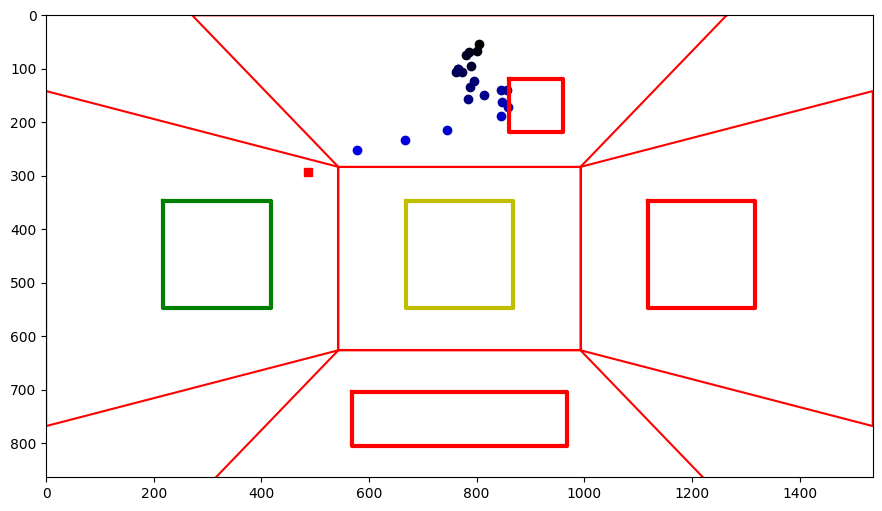

6 simple


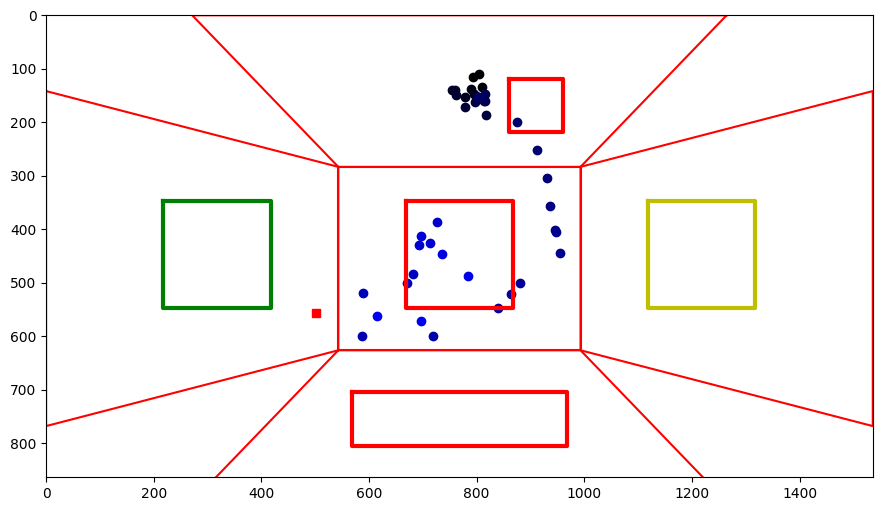

7 simple


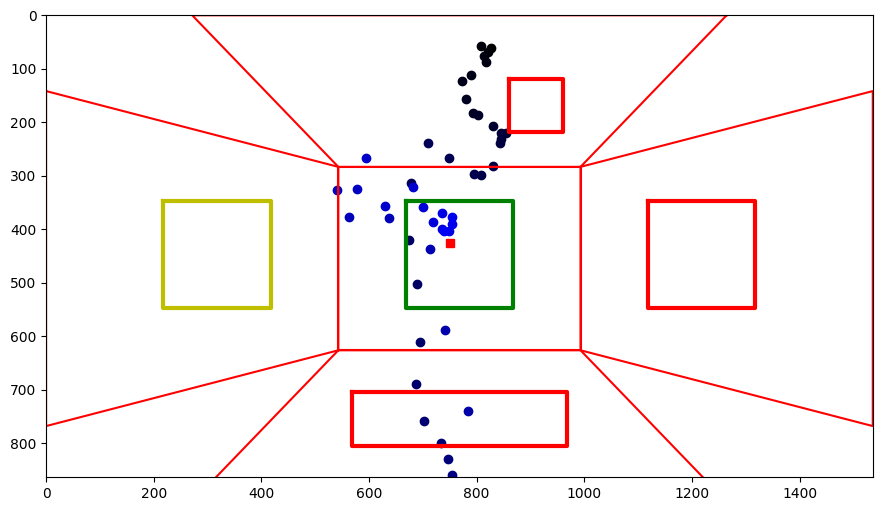

8 complex


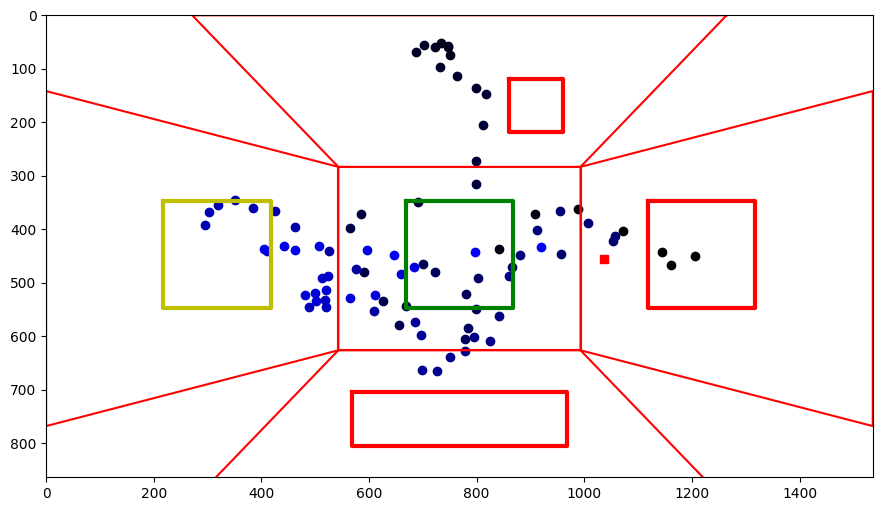

9 unambiguous


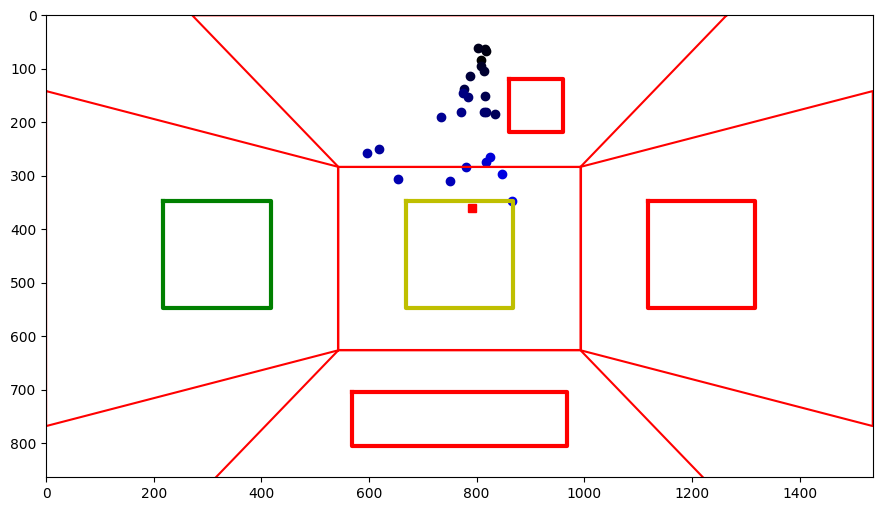

10 complex


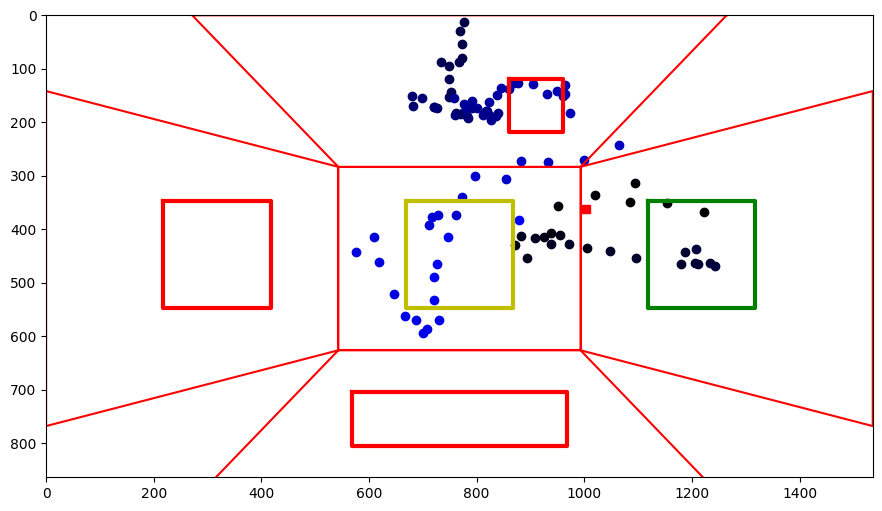

11 simple


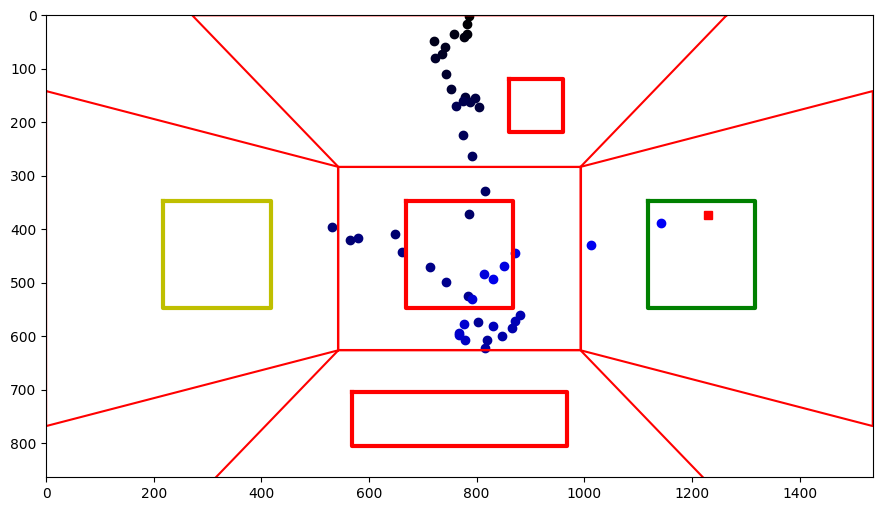

12 complex


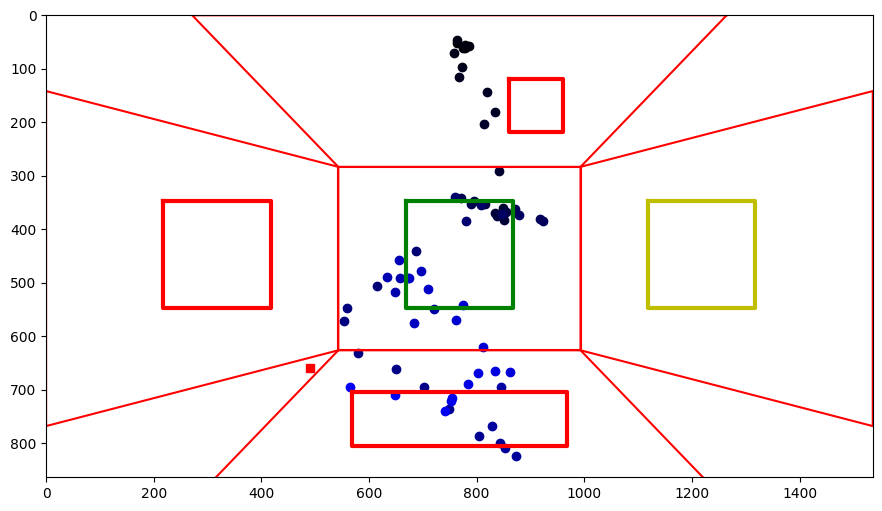

13 unambiguous


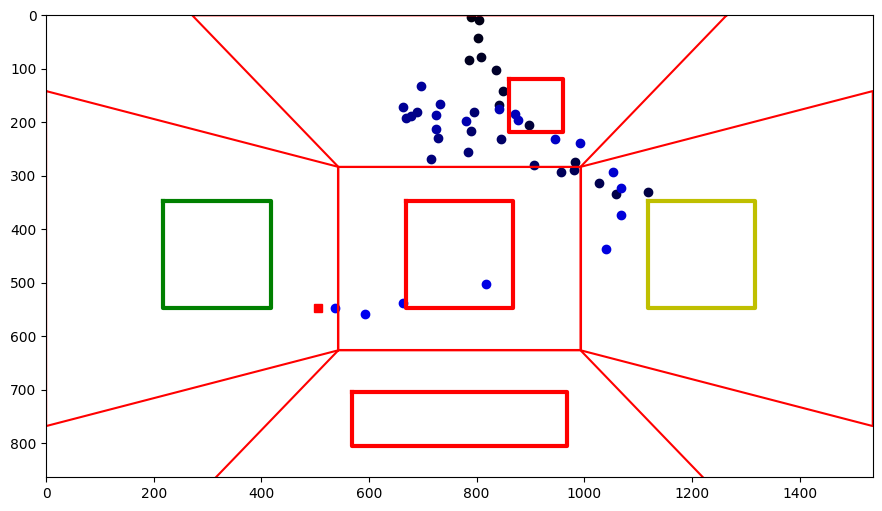

14 unambiguous


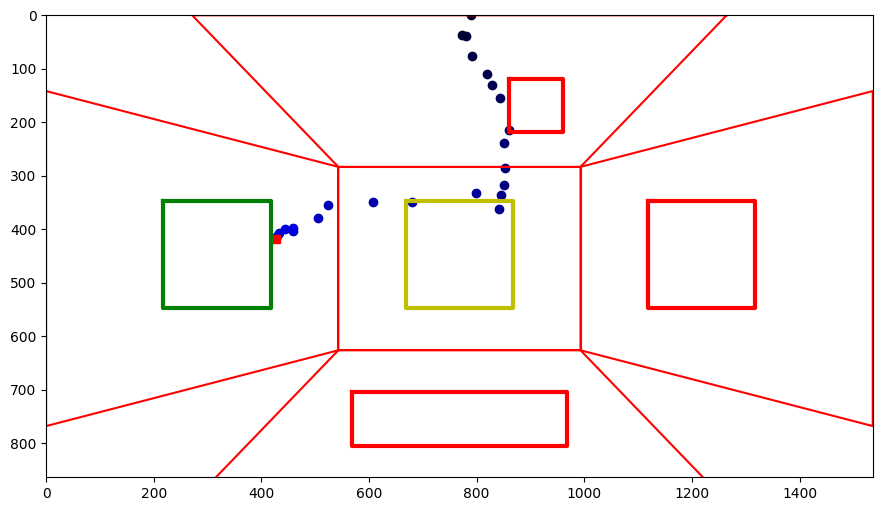

15 simple


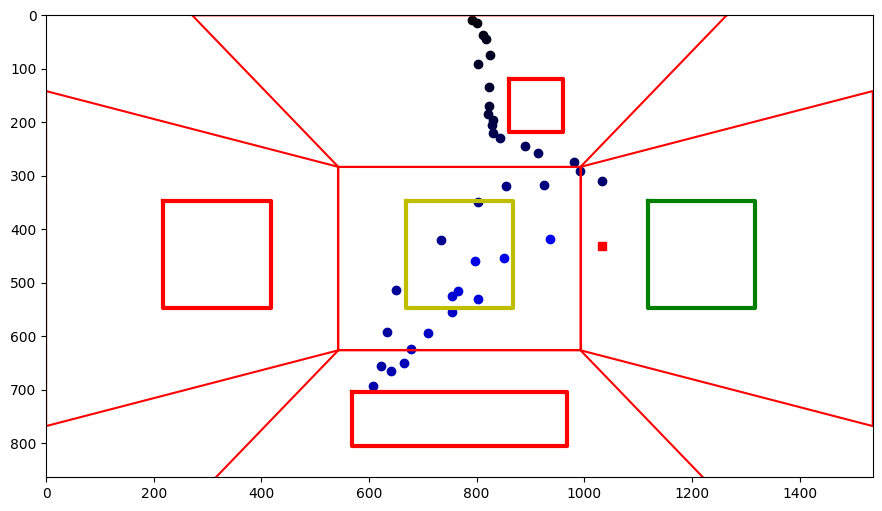

16 unambiguous


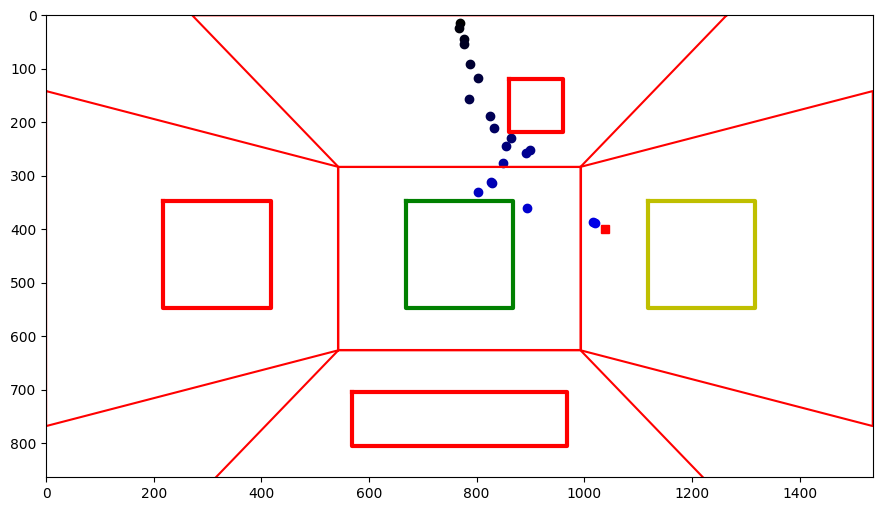

17 unambiguous


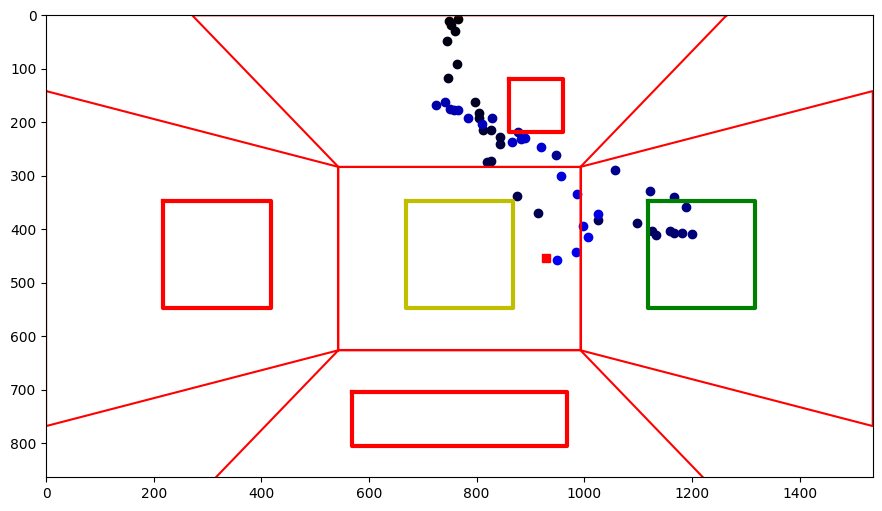

18 complex


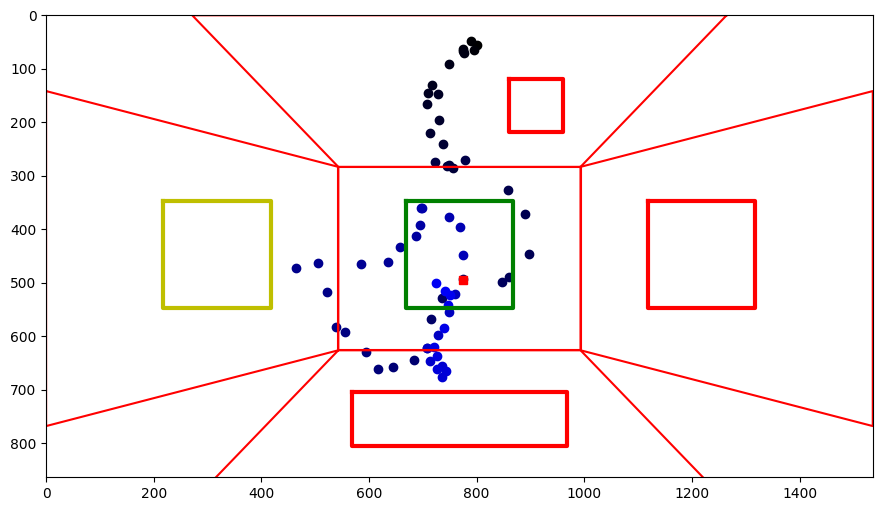

19 unambiguous


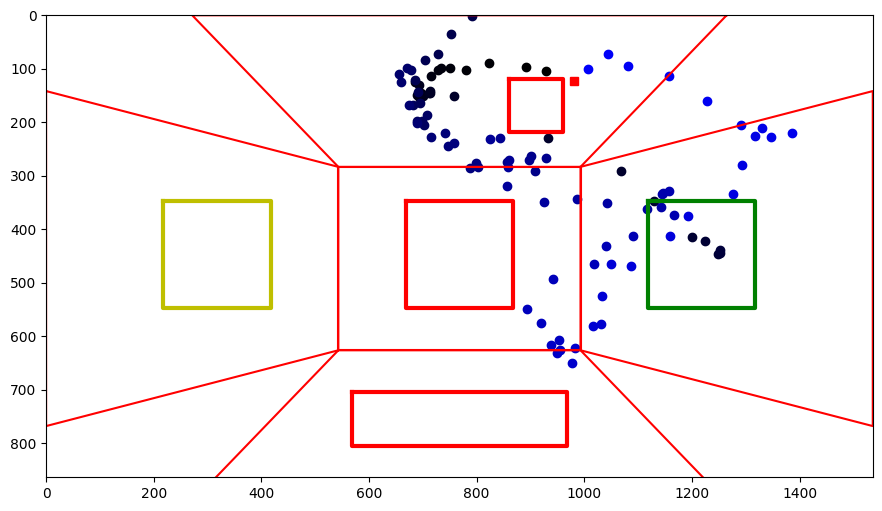

20 unambiguous


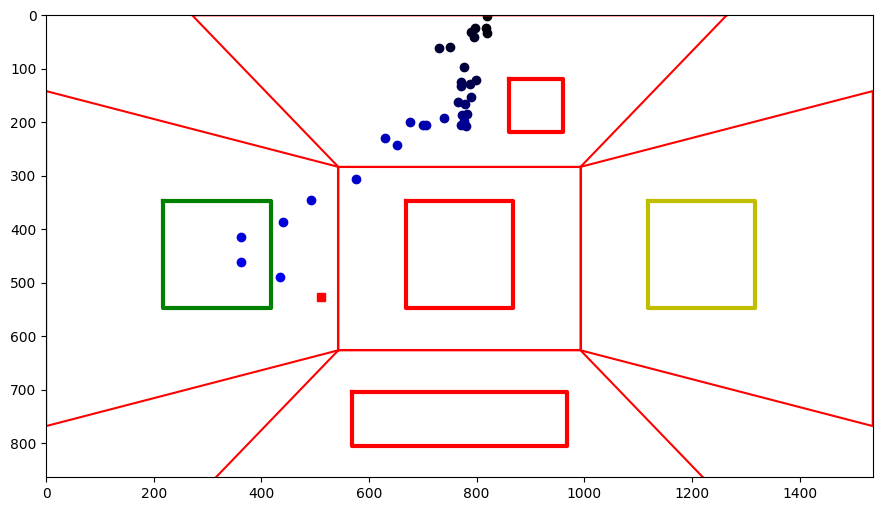

21 simple


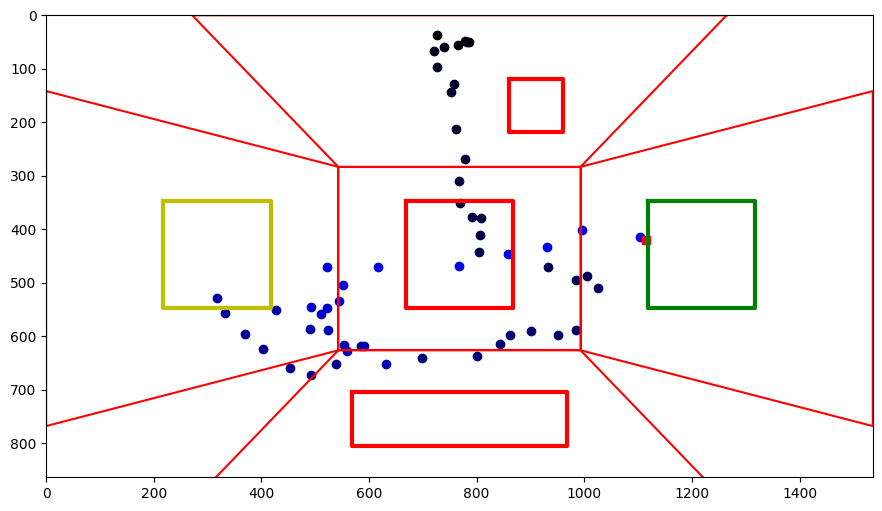

22 complex


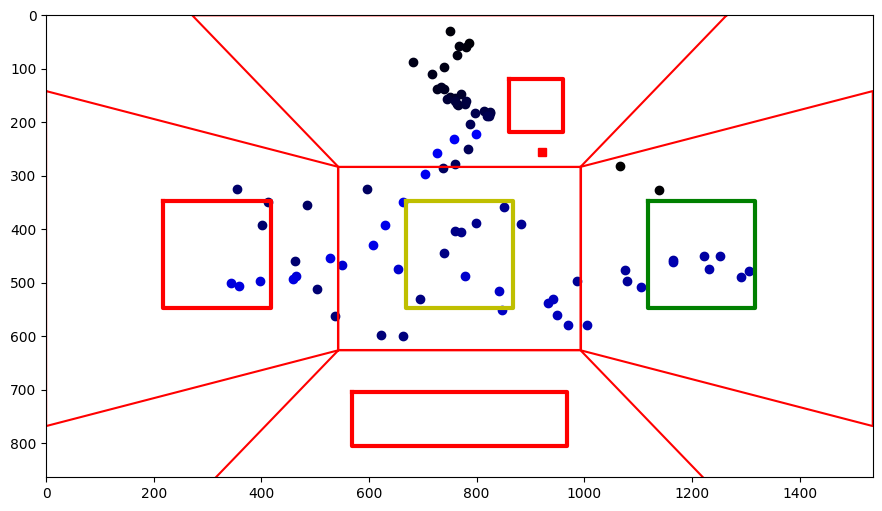

23 simple


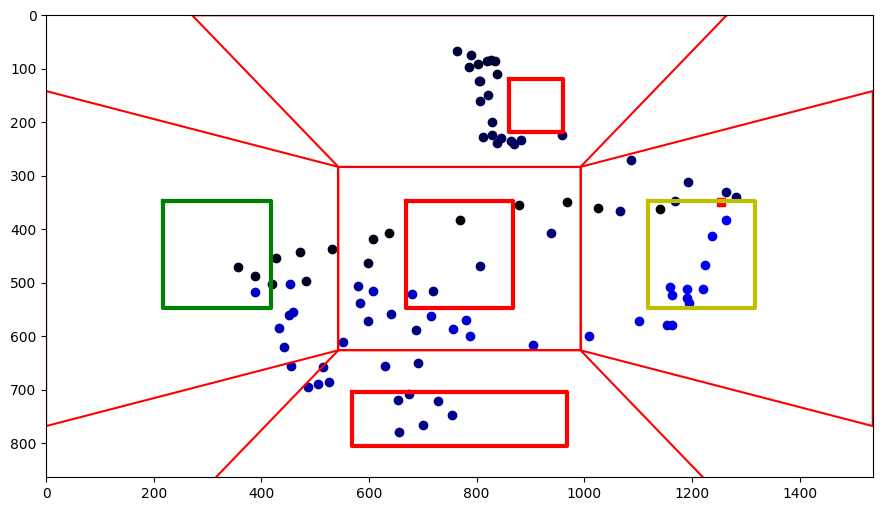

24 complex


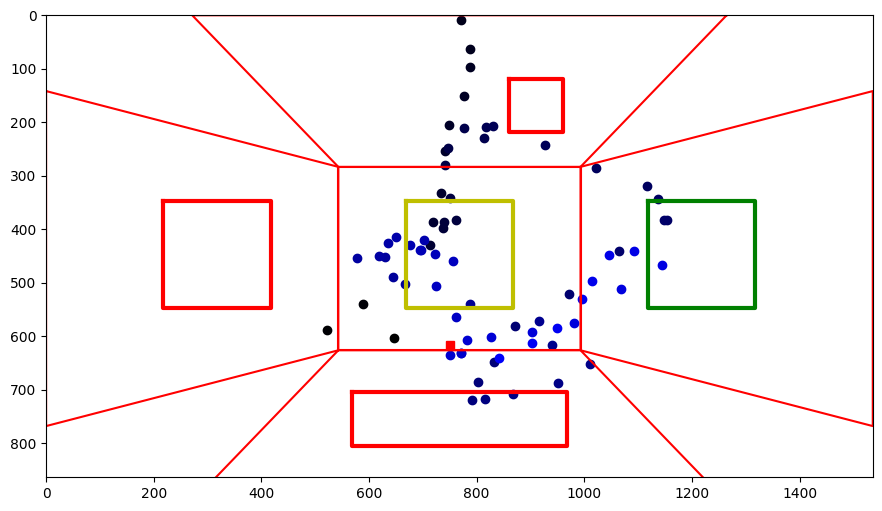

25 complex


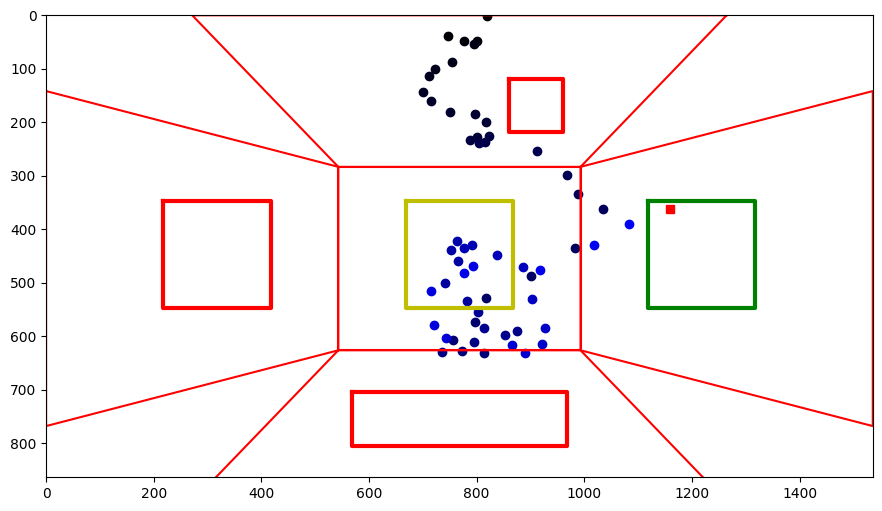

26 simple


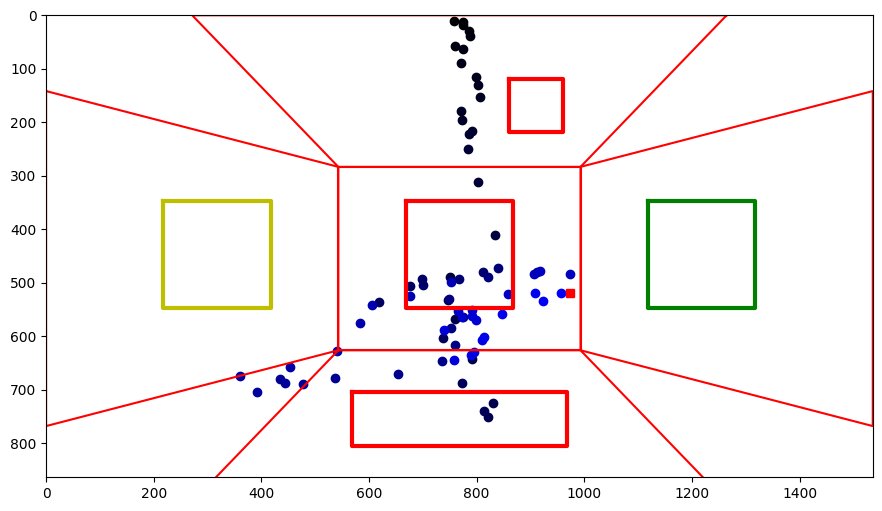

27 unambiguous


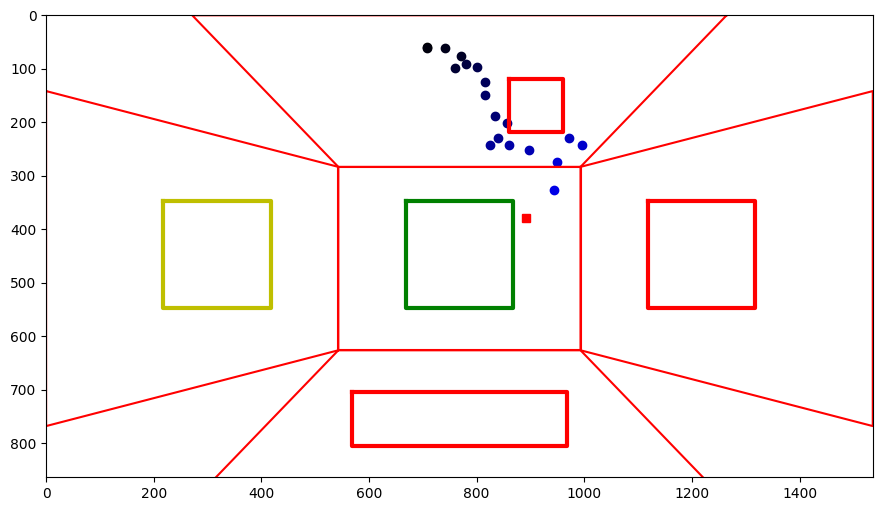

28 complex


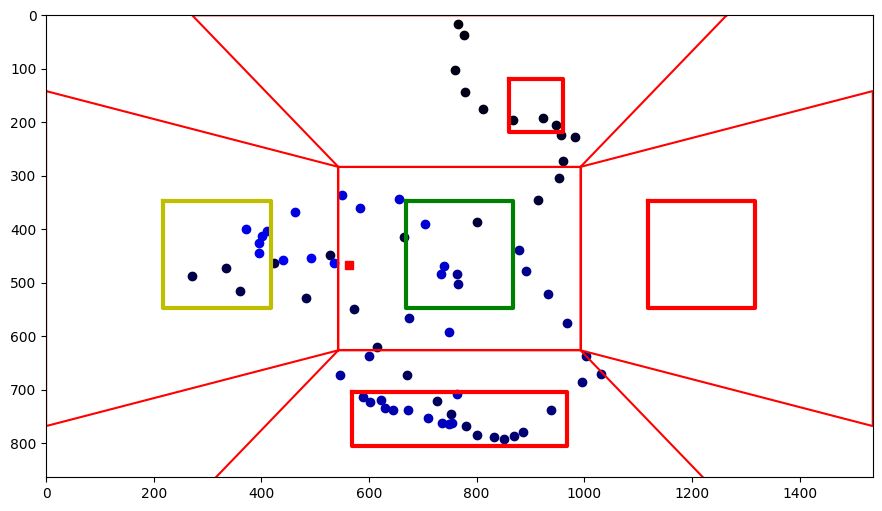

29 unambiguous


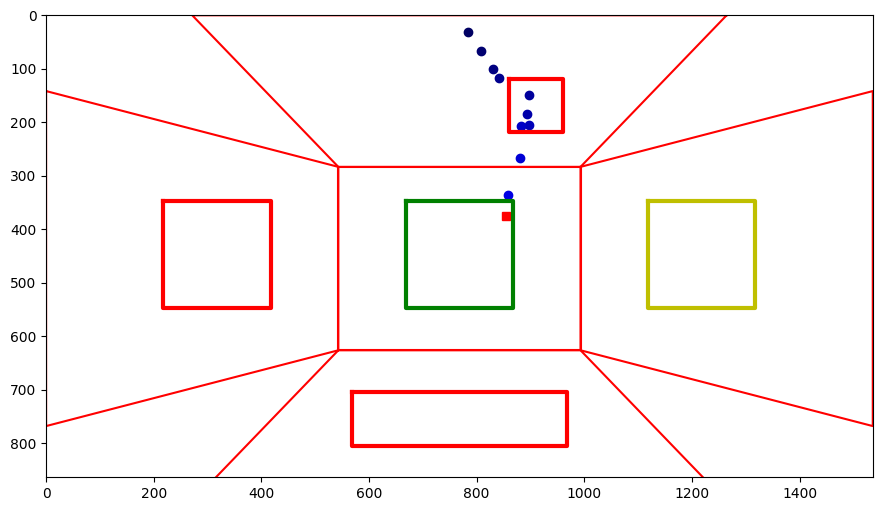

30 unambiguous


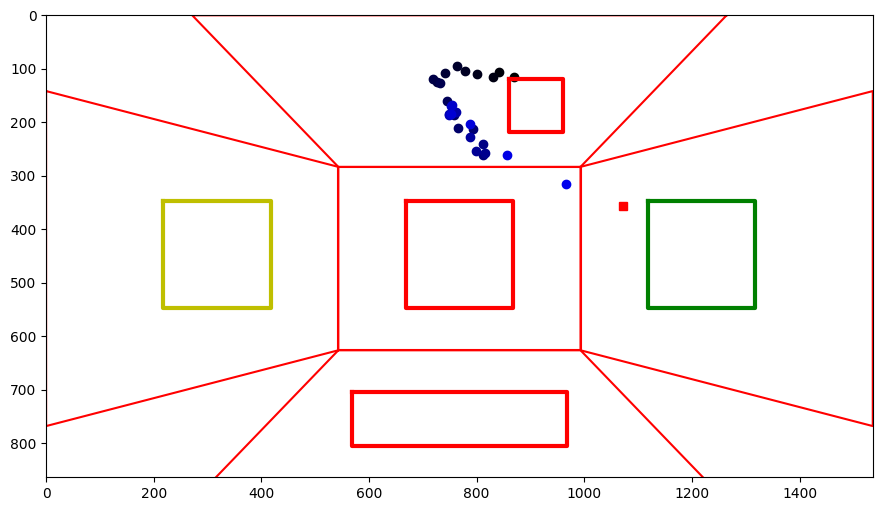

31 complex


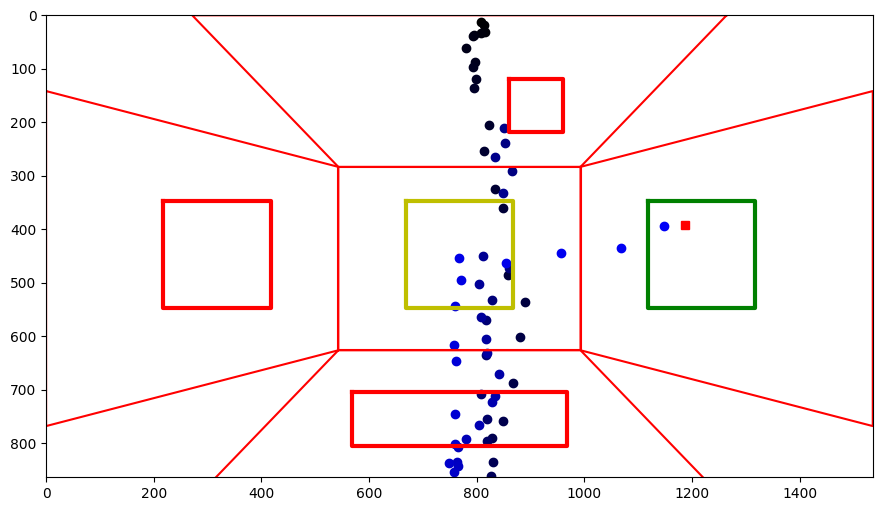

32 simple


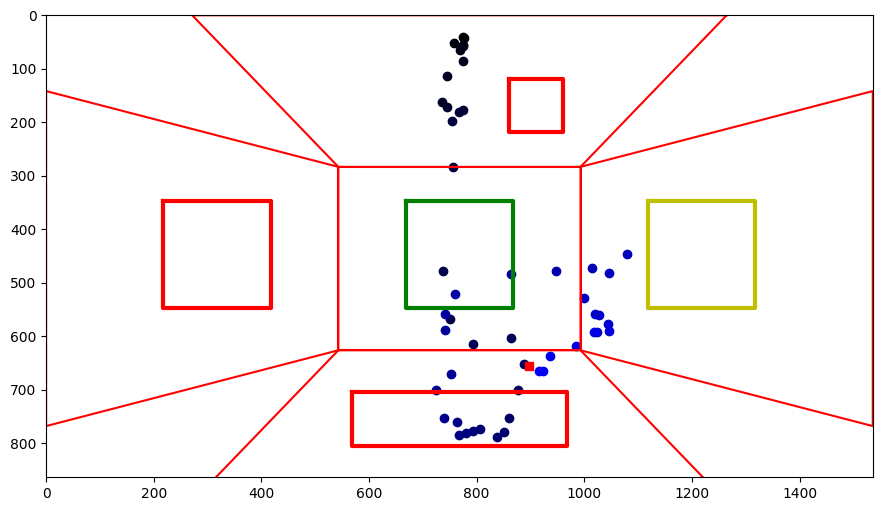

33 simple


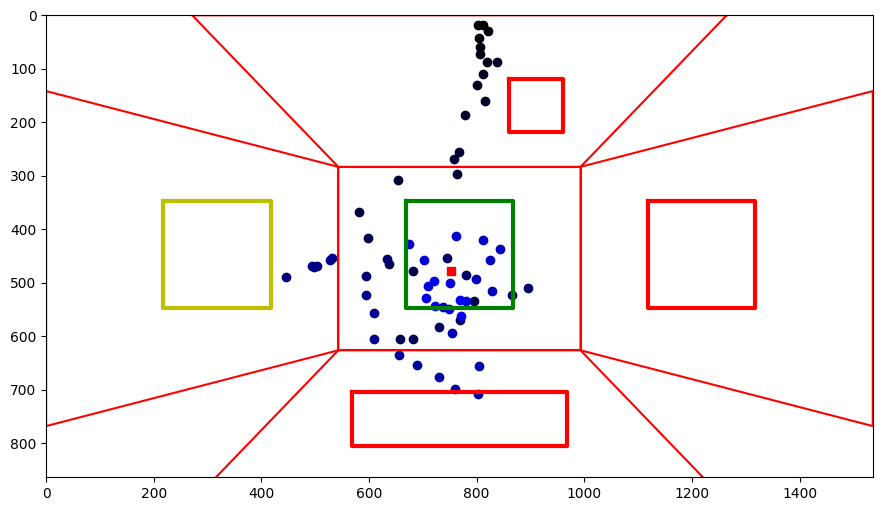

34 complex


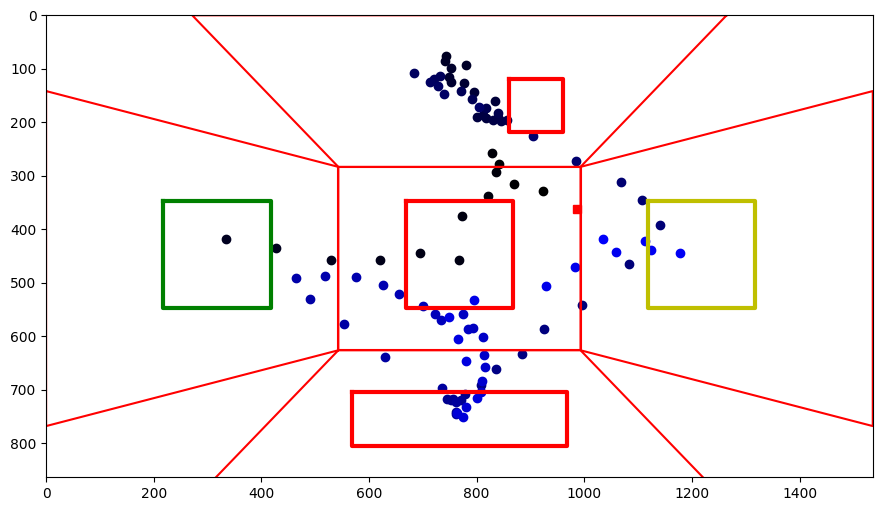

35 simple


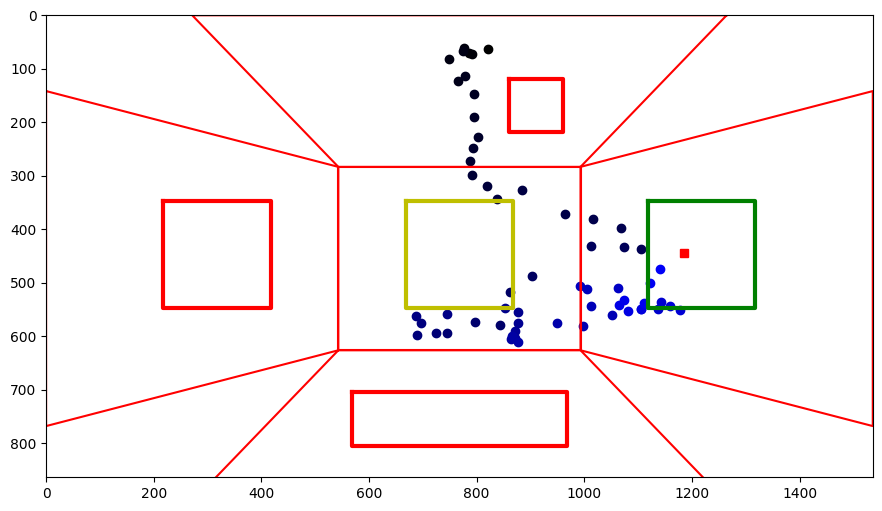

36 strategy_simple


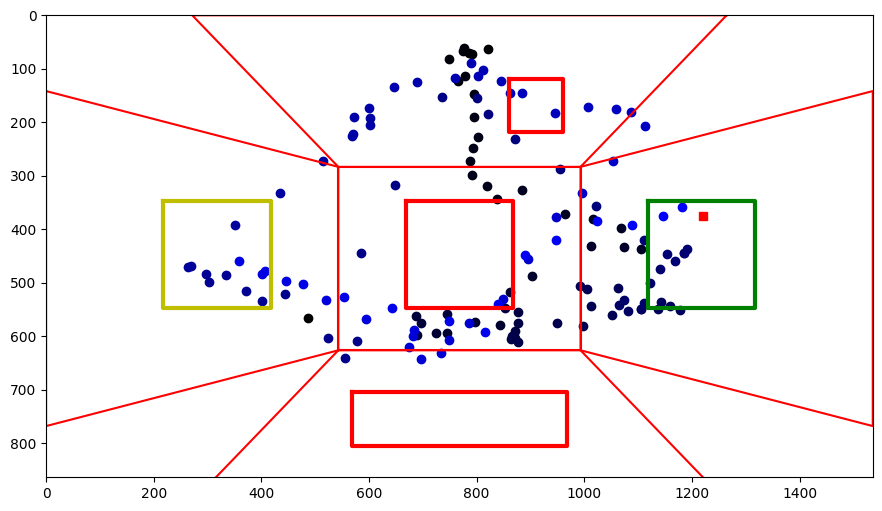

37 strategy_complex


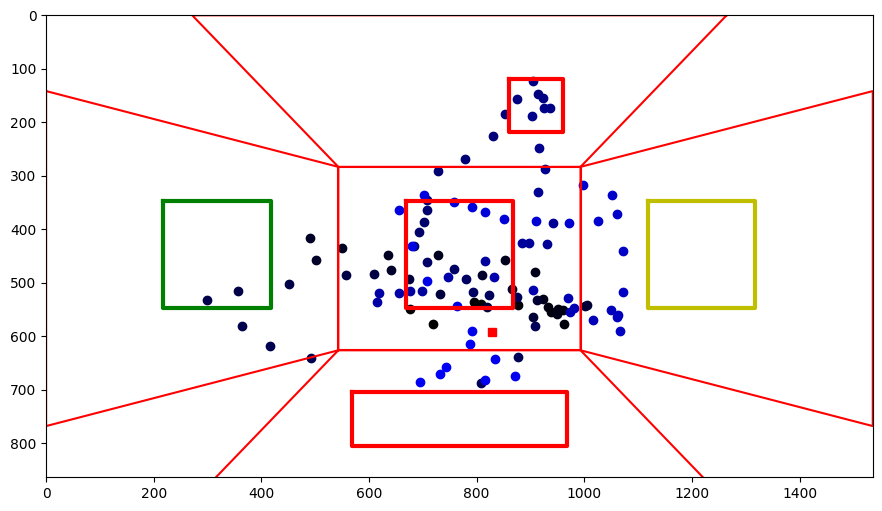

In [20]:
df = pd.read_csv(f'data/preprocessed_data/{df_name}.csv')
for column in dict_list_columns:
    df[column] = df[column].apply(lambda x: json.loads(x))
df['resolution'] = df['resolution'].apply(lambda x: json.loads(x))
participant = df.workerid.unique()[1]
print(participant)
sample = df[df['workerid']==participant]
pp.pprint(sample.iloc[0].deviceInfo)
pp.pprint(sample.iloc[0].calibrationPrecision)
resolution = sample.iloc[0].resolution

def plot_polygons(coords, plot):
    aoi = ['sent_msg', 'img1', 'img2', 'img3', 'available_msgs']
    for polygon_type in aoi:
        polygon = compute_polygon(polygon_type, coords)
        x,y = polygon.exterior.xy
        plot.plot(x, y, 'r')
        
aoi = ['img1', 'img2', 'img3', 'sent_msg', 'available_msgs']

for i in range(len(sample)):
    cur_sample = sample.iloc[i]
    gaze_sample = None
    gaze_sample = cur_sample.gaze
    x, y = [], []
    x = np.array([g['x'] for g in gaze_sample.values()])
    y = np.array([g['y'] for g in gaze_sample.values()])
    # print(len(x))
    # print(cur_sample.answerTime)
    print(i, cur_sample.type)
    # make a scatterplot on the left and a heatmap on the right, keep proportions of the screen
    
    # fig, axs = plt.subplots(1, 2, figsize=(2.2*(resolution[0]*6/resolution[1]), 6))
    plt.figure(figsize=(resolution[0]*6/resolution[1], 6))

    # make every next point slightly hue color on the plot to represent a scanpath
    for i in range(len(x)):
        if i == (len(x)-1):
            plt.plot(x[i], y[i], color=(1, 0, 0), marker='s')
        else:
            plt.plot(x[i], y[i], color=(0, 0, i/len(x)), marker='o')


    plt.xlim(0, resolution[0])
    plt.ylim(0, resolution[1])
    plt.gca().invert_yaxis()


    plot_polygons(cur_sample.coordinates, plt)
    for i, area in enumerate(aoi):
        cur_coords = cur_sample.coordinates[area]
        x_min = max(0, cur_coords['x'])
        x_max = cur_coords['x'] + cur_coords['width']
        y_min = max(0, cur_coords['y'])
        y_max = cur_coords['y'] + cur_coords['height']
        # plot boxes around AOI
        color = 'r'
        if cur_sample.trgtPos == i:
            color = 'g'
        if cur_sample.compPos == i:
            color = 'y'
        plt.plot([x_min, x_max, x_max, x_min, x_min], [y_min, y_min, y_max, y_max, y_min], color=color, linewidth=3)

    plt.show()

